In [6]:
# tensorflow ... must be run from the "tensorflow" optimized environment

from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np

# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and flatten the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the input size
input_size = 784  # for MNIST dataset, 28x28 images

# Define the encoder
input_img = Input(shape=(input_size,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
# The encoded representation is a lower-dimensional representation of the input data

# Define the decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_size, activation='sigmoid')(decoded)
# The decoded output should have the same size as the input data

# Define the autoencoder as a whole
autoencoder = Model(input_img, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder on the MNIST dataset
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True)

# Use the trained autoencoder for anomaly detection

# Reconstruct the test data
x_test_reconstructed = autoencoder.predict(x_test)

# Compute the reconstruction error between the input data and the reconstructed data
reconstruction_error = np.mean(np.square(x_test - x_test_reconstructed), axis=1)

# Define a threshold for anomaly detection
threshold = 0.01

# Identify anomalies as data samples with reconstruction error above the threshold
anomaly_indices = np.where(reconstruction_error > threshold)[0]

# Print the indices of anomalies
print("Indices of anomalies in the test data: ", anomaly_indices)


ModuleNotFoundError: No module named 'tensorflow'

In [51]:
# pytorch - must be run from pytorch optimized
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load the MNIST dataset and normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

# Define the autoencoder model and optimizer
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Use GPU if available, otherwise use CPU
autoencoder = Autoencoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 50
criterion = nn.BCELoss()  # Binary cross-entropy loss
for epoch in range(num_epochs):
    for i, (inputs, _) in enumerate(trainloader, 0):
        inputs = inputs.to(device).view(-1, 784)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

# Evaluate the autoencoder on the test data




In [33]:
reconstruction_errors = []
with torch.no_grad():
    for i, (inputs, _) in enumerate(testloader, 0):
        inputs = inputs.to(device).view(-1, 784)
        outputs = autoencoder(inputs)
        reconstruction_error = torch.mean((outputs - inputs) ** 2, dim=1)
        reconstruction_errors.extend(reconstruction_error.cpu().numpy().tolist())

reconstruction_errors = np.array(reconstruction_errors)
threshold = np.percentile(reconstruction_errors, 95) # Set threshold at the 95th percentile of reconstruction error
anomaly_indices = np.where(reconstruction_errors > threshold)[0]

# Print the indices of anomalies
print("Indices of anomalies in the test data: ", anomaly_indices)

Indices of anomalies in the test data:  [   2   29   31   40   57   59   96  122  143  145  154  175  176  178
  180  189  191  195  203  204  224  227  228  229  239  251  272  279
  283  302  332  341  354  357  377  378  383  385  388  393  419  427
  443  473  480  483  489  499  504  506  523  542  543  667  675  682
  689  695  696  716  725  749  754  755  767  783  809  824  835  836
  842  883  889  900  907  918  920  929  931  948  959  963  964  984
  988 1017 1030 1037 1038 1039 1040 1054 1075 1083 1097 1122 1137 1138
 1179 1189 1216 1224 1236 1242 1254 1257 1260 1274 1280 1295 1329 1338
 1355 1358 1360 1368 1392 1397 1412 1472 1483 1484 1500 1528 1548 1555
 1593 1596 1630 1657 1659 1673 1701 1703 1704 1707 1709 1715 1716 1728
 1736 1753 1773 1780 1791 1829 1830 1835 1836 1862 1868 1897 1901 1922
 1948 1986 1988 2010 2013 2027 2034 2041 2051 2059 2063 2071 2093 2135
 2137 2164 2171 2175 2206 2228 2239 2245 2273 2276 2277 2283 2315 2325
 2357 2359 2409 2411 2416 2418 2421 2

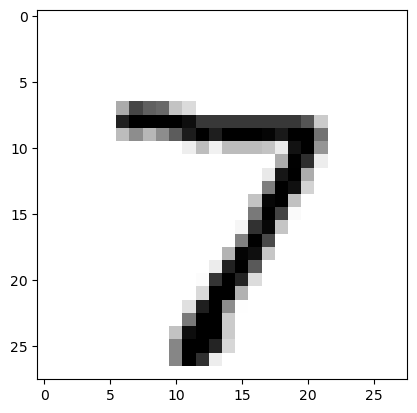

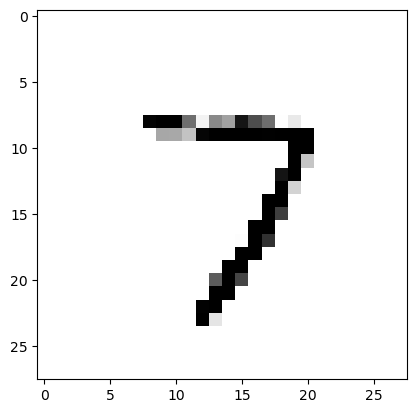

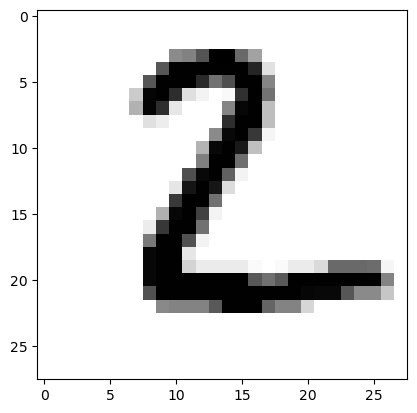

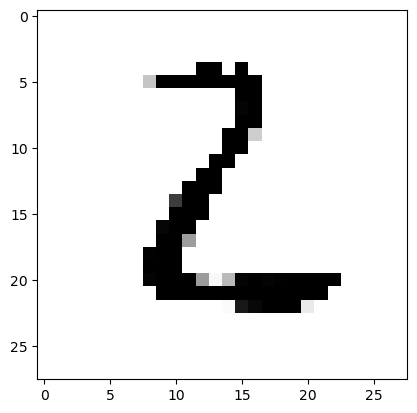

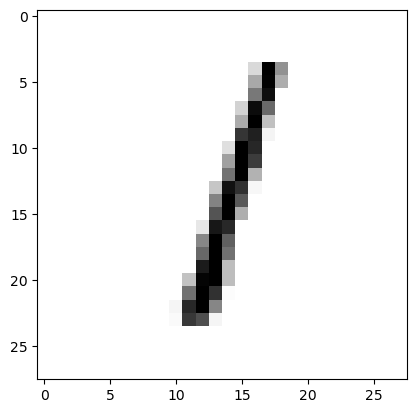

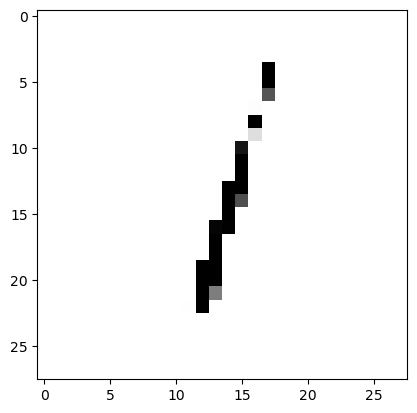

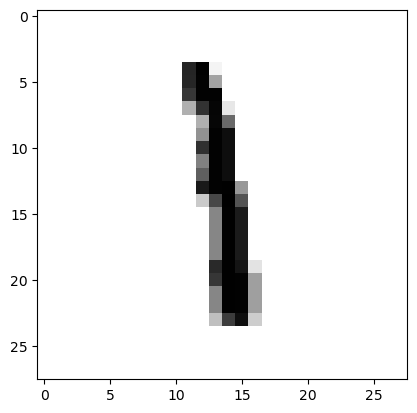

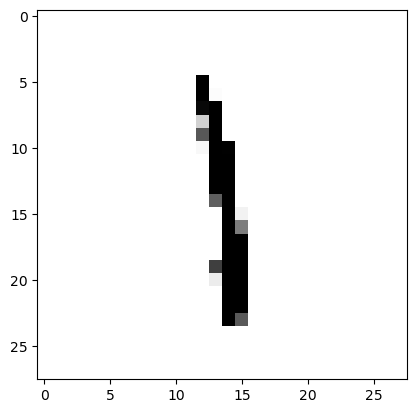

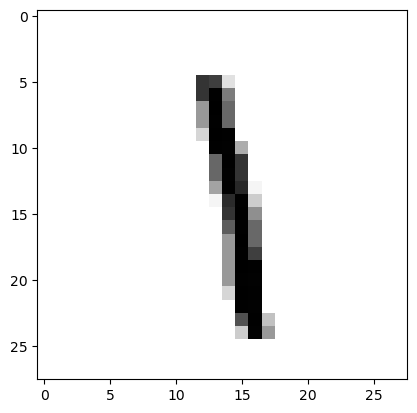

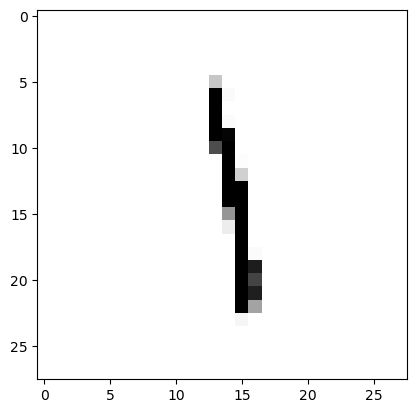

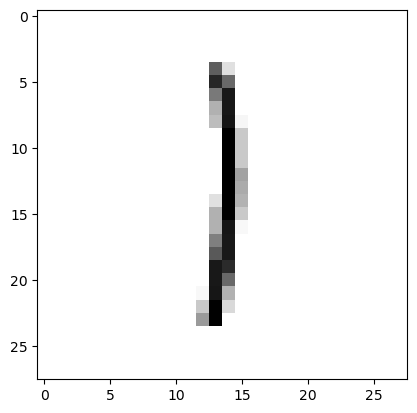

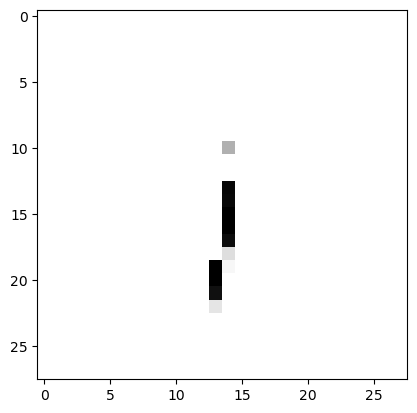

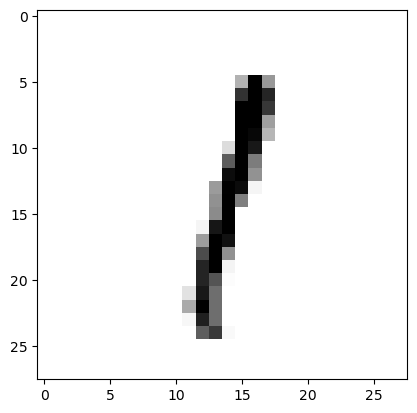

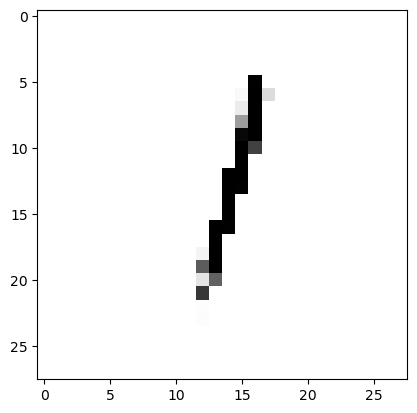

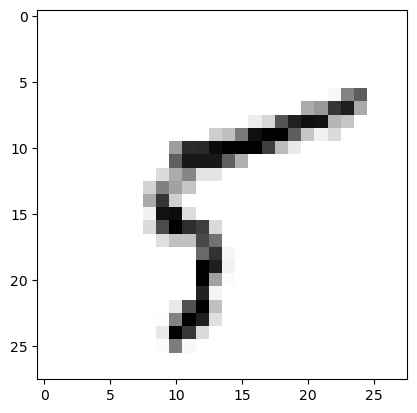

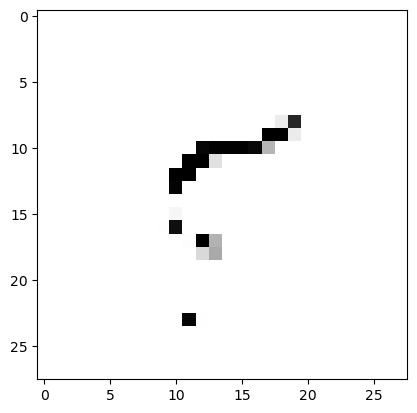

In [63]:
import matplotlib.pyplot as plt
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader, 0):
        inputimgs = [inputs[i] for i in [0,1]]
        for img in inputimgs:
            plt.imshow(img[0], cmap="gray_r")
            plt.show()
            inputimg = img[0].to(device).view(-1, 784)
            outputs = autoencoder(inputimg)
            plt.imshow(outputs.to("cpu").view(28, 28), cmap="gray_r")
            plt.show()
        inputimgs = [inputs[i] for i in [2, 29, 31, 40, 57, 59]]
        for img in inputimgs:
            plt.imshow(img[0], cmap="gray_r")
            plt.show()
            inputimg = img[0].to(device).view(-1, 784)
            outputs = autoencoder(inputimg)
            plt.imshow(outputs.to("cpu").view(28, 28), cmap="gray_r")
            plt.show()
        break
